## James Griffin 
### Rivers Report 

Rocky Mountain River Drainage

Rivers play an important role in any ecosystem. Rivers carry water and nutrients to areas all around the earth. They play a very important part in the water cycle, acting as drainage channels for surface water. Rivers provide excellent habitat and food for many of the earth’s plants and animals. In the Rocky Mountain Region of the United States, river valleys and plains provide fertile soils and are the primary source of water for living. Farmers in the region irrigate their cropland using water carried by irrigation ditches and reservoirs from nearby rivers.

In this analysis you will be analyzing how various factors (human, river network and climate) impact the overall waterflow of various rivers in the U.S. Rocky Mountains. The variable Metric in the dataset Rivers.csv is a standardized (unitless) measure of overall water flow for various rivers in the Rocky Mountain region. Higher values indicate larger overall flow. Along with Metric are various other potential explanatory variables that may promote or preclude higher river flow. Descriptions of of these variables are included in the supplmental file Metadata.csv. Also included in the dataset are the latitude/longitude coordinates of each river station where the data was collected. The locations of the stations are shown below.

In your analysis, you may ignore any potential spatial correlation (since we haven’t covered this yet in the class). Also, try not to do any variable selection. Make sure your report answers the following questions:

1. What are the biggest climate / river network / human factors that impact overall river flow.
2. How well do the factors you listed in #1 explain overall flow?
3. How predictive of overall flow are these identified factors?

In [1]:
#importing a bunch of stuff that I may use 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings; warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV


In [2]:
#defining some meta funcitons that i'll use later 

def trendline(xd, yd, order=1, c='r', alpha=1, Rval=False):
    """Make a line of best fit"""
    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)
    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0
    minxd = np.min(xd)
    maxxd = np.max(xd)
    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept
    #Plot trendline
    plt.plot(xl, yl, c, alpha=alpha)
    #Calculate R Squared
    p = np.poly1d(coeffs)
    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot
    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(yd) + 0.2 * np.min(yd),
                 '$R^2 = %0.2f$' % Rsqr)
    else:
        #Return the R^2 value:
        return Rsqr

### reading in data 

In [3]:
data = pd.read_csv('../data/rivers.csv')
data_dict = pd.read_csv('../data/Metadata.csv')
data.shape


(102, 98)

In [4]:
#grouping all of my categories into different dfs to answer question 1 
#humans
hd = data_dict.loc[data_dict['Category'] == 'Humans']
hl = hd['orig.vname'].tolist()
h = data[hl]

#climate
cd = data_dict.loc[data_dict['Category'] == 'Climate']
cl = cd['orig.vname'].tolist()
c = data[cl]

#river network
nd = data_dict.loc[data_dict['Category'] == 'Network']
nl = nd['orig.vname'].tolist()
nl.remove("WSNO")#for some reason WSNO was not in the data so had to remove from list
n = data[nl]

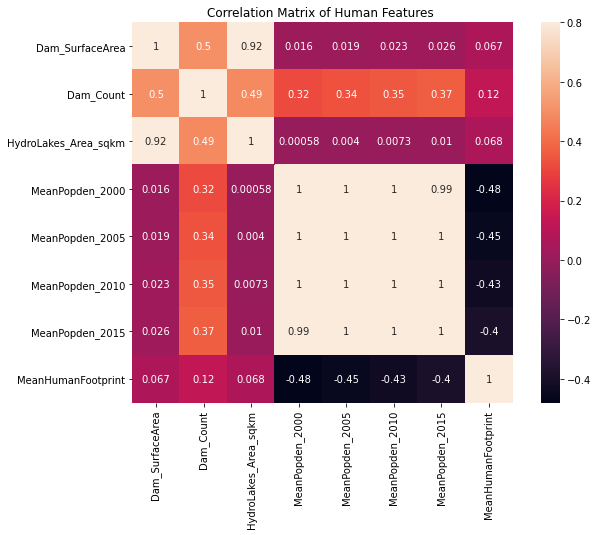

In [5]:
#lets visualize this one more way 
corr_mat = h.corr()
f, ax = plt.subplots(figsize = (10,7))
sns.heatmap(corr_mat,vmax=.8,square=True, annot = True)
plt.title("Correlation Matrix of Human Features ")
plt.show()

ok so I'm wonderinf if to reduce the feature set a bit we could maybe take the mean temps / persperation 
for each month and group them into like, winter, spring, summer, fall... just an idea 
and I'm thinking that the cumulitive preceptiation will be very multi colinear with the averages... right? 
which should colinear with temperatures as well, which will be colinear with bio1, 
ok so this is screaming non linearity, which makes sense, it's the real world enviorment, where all of these 
variables ar somewhat dependant on eachother. 

so really the only thing to do going forward is to use one of the non linear techniques we talked about in 
class to find the features that are most impacful on out metric 

but we need scale the data, it's tough because we have our precipitation numbers in milimeters, some are percents, some are numbers per kilometer, some are squared kilometers, some are meters so I need to figure out how I am going to scale everything, because this is important for penalized regression 

#1 ok so What are the biggest climate / river network / human factors that impact overall river flow.

starting with climate then 

In [6]:
def scale_cat_df(cat_df):
    scaler = StandardScaler()
    cat_scaled = scaler.fit(cat_df)
    scaled_cat = scaler.transform(cat_df)
    return scaled_cat

cols = data.drop(columns = ['Metric'])
sx = scale_cat_df(cols)
sc = scale_cat_df(c)
sh = scale_cat_df(h)
sn = scale_cat_df(n)

0.06
mean_absolute_error
0.4140835175797962
 
root_mean_squarered_error
0.6162284853287658


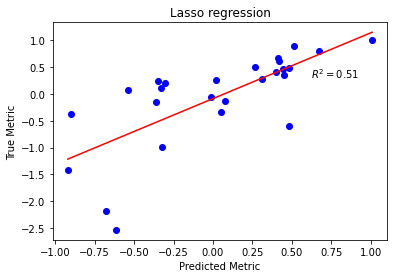

Cross-validation scores: [0.29097532 0.45864528 0.60191084 0.36378664 0.73251603]
Average cross-validation score: 0.49
Test set score alpha = 0.005 : 0.49
Number of features used: 12


,cols,scores
13,MeanPrec01,0.074365
15,MeanPrec03,0.084312
19,MeanPrec07,-0.036239
26,CumPrec01,0.029450
28,CumPrec03,0.232332
29,CumPrec04,0.083835
31,CumPrec06,0.076510
42,bio4,-0.019767
48,bio10,-0.255632
53,bio15,-0.129608


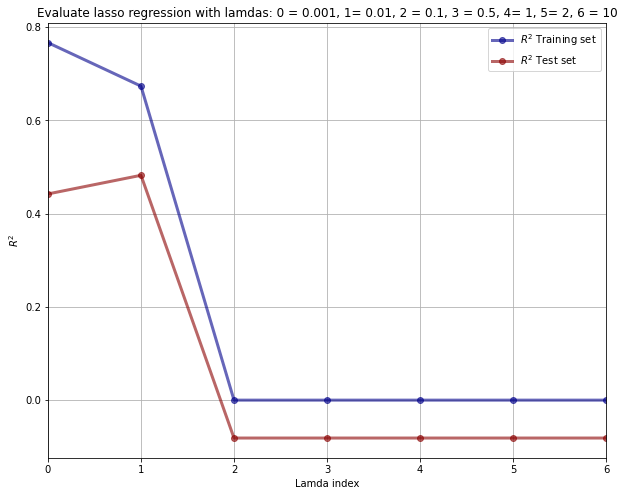

In [7]:
def lasso_cols(y, scaled_df, alpha_level, cat_df):
    '''
    Parameters:
    y = target variable, 
    scaled_df = a scaled data frame from above
    alpha_level = learning rate for peanlizing the regression - a hyper parameter we can tune to ensure that 
    we are not over fitting
    cat_df = a category of the data that we are looking at, human, climate, network etc. 
    ''' 
    
    #split into train and testing
    X_train, X_test, y_train, y_test = train_test_split(scaled_df, 
                                                    y, 
                                                    random_state=42)
    
    #ok now cross validating 
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)

    #fit model
    model.fit(X_train, y_train)
    #display lambda that produced the lowest test MSE
    print(model.alpha_)

    lasso_cv1 = Lasso(alpha=alpha_level, max_iter=1000, normalize = True).fit(X_train, y_train)
    #five fold cross validation 
    scores = cross_val_score(lasso_cv1, X_train, y_train, cv=5)
    
    t = lasso_cv1.predict(X_test)
    
    mae_rf = mean_absolute_error(t, y_test)
    print("mean_absolute_error")
    print(mae_rf)    
    print(" ")
    print("root_mean_squarered_error")
    mse_rf = (mean_squared_error(t, y_test))**(1/2)
    print(mse_rf)

    plt.scatter(x = t, y = y_test, color = "blue")
    plt.title("Lasso regression")
    plt.ylabel('True Metric')
    plt.xlabel("Predicted Metric")
    trendline(t, y_test)
    plt.show()
    
    
    print("Cross-validation scores: {}".format(scores))
    print("Average cross-validation score: {:.2f}".format(scores.mean()))
    #to know if we are chosing the right alpha, we need tot look at our test and training scores 
    #and this will give us our test score, to see if we are over fitting 
    print("Test set score alpha = " +str(alpha_level)+" : {:.2f}".format(lasso_cv1.score(X_test, y_test)))
    print("Number of features used:", np.sum(lasso_cv1.coef_ != 0))
    new_df = pd.DataFrame()
    la_coef = list(lasso_cv1.coef_)
    cols = list(cat_df.columns)
    new_df['cols'] = cols
    new_df['scores'] = la_coef
    non_0 = new_df.loc[new_df.scores != 0 ]
    
    #lasso_cv1.pred_num
    
    
    lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
    l_num = 7
    pred_num = scaled_df.shape[1]

    # prepare data for enumerate
    coeff_a = np.zeros((l_num, pred_num))
    train_r_squared = np.zeros(l_num)
    test_r_squared = np.zeros(l_num)


    # enumerate through lambdas with index and i
    for ind, i in enumerate(lambdas):    
        reg = Lasso(alpha= i, max_iter=1000, normalize = True).fit(X_train, y_train)

        coeff_a[ind,:] = reg.coef_
        train_r_squared[ind] = reg.score(X_train, y_train)
        test_r_squared[ind] = reg.score(X_test, y_test)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
    plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
    plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
    plt.xlim(0, 6)
    plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
    plt.legend(loc='best')
    plt.grid()

    
    
    return non_0, t

c_important, t_vals = lasso_cols(data.Metric, sc, .005, c,)
c_important

Ok so alpha is a tuning parameter, and above I was playing around with different values of which alpha would give me the best score. Surprisingly, when alpha is really small, I am really over fitting. the training scores were almost double the test scores, and I was even cross validating, which was weird. Python defauls lasso to have an alpha of 1, so I went to alpha = .01, but we only were using 8 features from the data set. Because our  average cross validation score is basically the same as our test score, so that is good, if we change it more, we get vastly different scores. here are the columns that are the answer to the climate features that are important 

0.03
mean_absolute_error
0.5737078125507376
 
root_mean_squarered_error
0.832034127818289


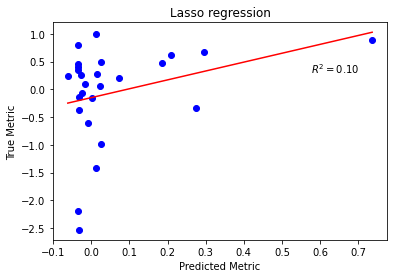

Cross-validation scores: [ 0.14133662 -0.11900586  0.14982138  0.34370175  0.20796963]
Average cross-validation score: 0.14
Test set score alpha = 0.01 : 0.06
Number of features used: 2


,cols,scores
2,HydroLakes_Area_sqkm,0.331915
3,MeanPopden_2000,-0.026403


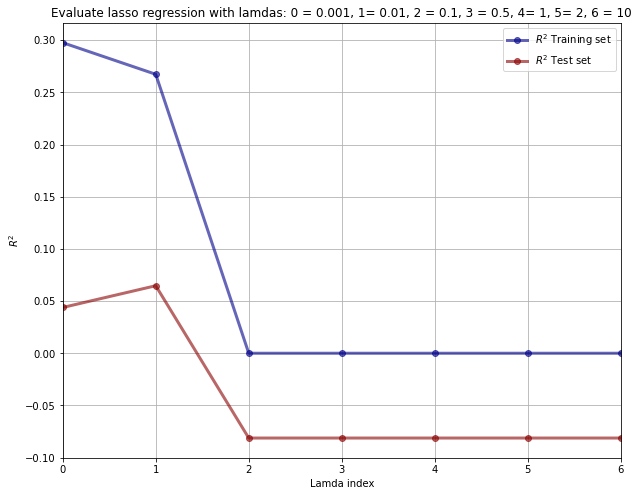

In [8]:
h_important, h_test = lasso_cols(data.Metric, sh, .01, h)
h_important

0.0
mean_absolute_error
0.5933829202688444
 
root_mean_squarered_error
0.8936914094788142


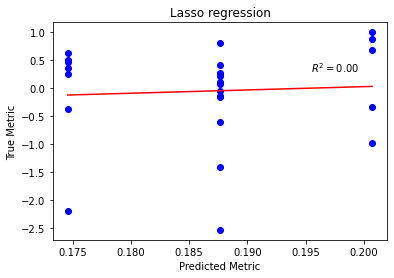

Cross-validation scores: [-0.04967916  0.0038758  -0.04978742  0.07772638 -0.24959726]
Average cross-validation score: -0.05
Test set score alpha = 0.05 : -0.08
Number of features used: 1


,cols,scores
8,gord,0.011777


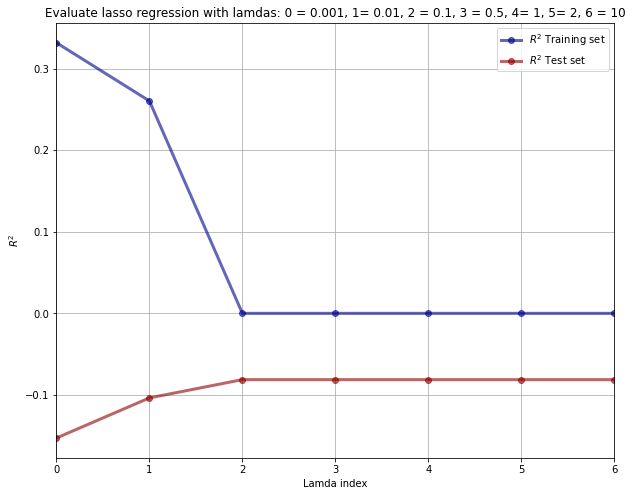

In [9]:
n_important, n_test =lasso_cols(data.Metric, sn, .05, n)
n_important

Now gonna run lasso on all of the columns, see what happens, see if I  get the same feature set back as the combined climate, human and network lassos 

0.03
mean_absolute_error
0.360482155795872
 
root_mean_squarered_error
0.5339843352515281


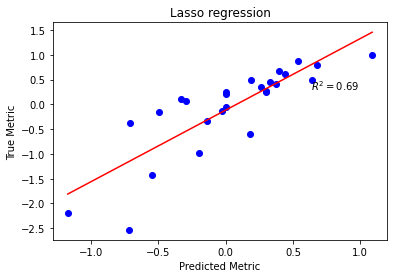

Cross-validation scores: [0.38640471 0.55748512 0.70465953 0.51484284 0.85211983]
Average cross-validation score: 0.60
Test set score alpha = 0.005 : 0.61
Number of features used: 18


,cols,scores
6,gelev_m,0.023852
8,gord,0.246633
9,PathLength,0.038640
39,CumPrec03,0.055695
41,CumPrec05,0.086383
59,bio10,-0.067368
64,bio15,-0.088082
65,bio16,-0.024902
67,bio18,-0.074269
69,cls1,0.028149


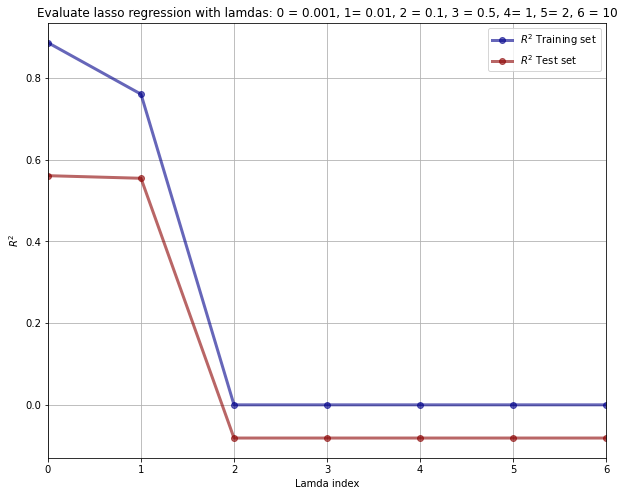

In [10]:
all_cols, all_test = lasso_cols(data.Metric, sx, .005, cols)
all_cols

#### 2 - how well do the features from 1 predict the metric? 

Ok so we have established that the data is very multi colinear, and that regular linear techniques will not work as we try to predict the metric in question. So we need to use non linear methods as we approach the final problem. 

In [11]:
imp_feats = c_important.cols.tolist() + h_important.cols.tolist()+ n_important.cols.tolist()
X2 = data[imp_feats]

0.0
mean_absolute_error
0.414483651610091
 
root_mean_squarered_error
0.6094816221472135


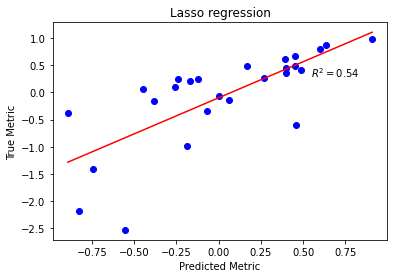

Cross-validation scores: [0.28872669 0.21458116 0.66702647 0.56626565 0.81076463]
Average cross-validation score: 0.51
Test set score alpha = 0.005 : 0.50
Number of features used: 11


(                    cols    scores
 1             MeanPrec03  0.457720
 4              CumPrec03  3.314918
 5              CumPrec04  1.267400
 6              CumPrec06  0.093222
 7                   bio4 -0.158659
 8                  bio10 -0.412052
 9                  bio15 -0.161636
 10                 bio16 -0.003833
 11                 bio18 -0.554932
 12  HydroLakes_Area_sqkm  3.798409
 14                  gord  0.371428,
 array([ 0.39473798, -0.74301445, -0.24337838, -0.18819295,  0.45284572,
        -0.26153318,  0.45512976, -0.38400246,  0.39834905,  0.16772882,
         0.59647811,  0.45406901,  0.48721078, -0.89321799, -0.55304492,
        -0.12155928, -0.16949213,  0.26692676,  0.3973073 ,  0.05867292,
        -0.82836382,  0.63477234,  0.90803229, -0.45060563, -0.06933094,
         0.00295769]))

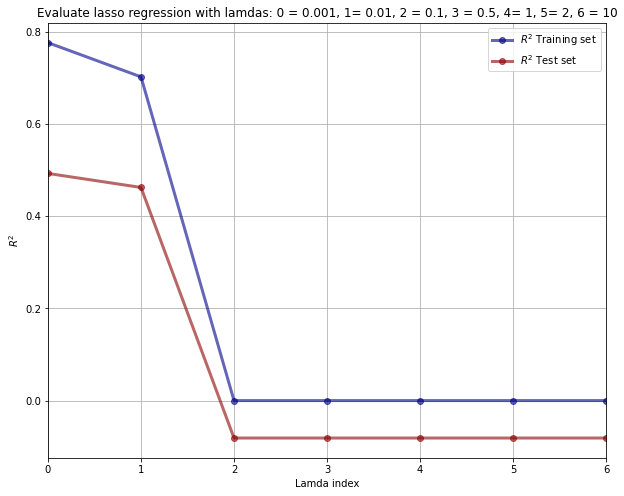

In [12]:
lasso_cols(data.Metric, X2, .005, X2)

In [13]:
def train_predict_xgb(y, df):
    target = y
    X = df 
    #splitting into train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, 
                                                    random_state=17)
    print("len of training")
    print(len(X_train))
    print('len of testing')
    print(len(X_test))
    
    xclass = xgb.XGBRegressor()
    
    parameters = {
        'learning_rate': [.01, .02, .03, .04, .05], # np.arange(.01, 1, .01), #LOOK AT INCREASING STEP SIZES
        'max_depth': [25, 30, 35, 37, 40, 45, 50], #np.arange(1, 100, 1), #
        #'min_child_samples': [1, 3, 5],
        #'subsample': np.arange(.3, .7, .1),
        'colsample_bytree': np.arange(.1, 1, .1),
        'n_estimators' :[700, 800, 900, 1000, 1100, 1200], #np.arange(100, 1200, 100), #
        #'objective': ['reg:squarederror'],  
        }
 
    gs = RandomizedSearchCV(xclass, parameters, cv = 5)
    gs.fit(X_train, y_train) 
    boost_preds = gs.predict(X_test)
    
    mae_rf = mean_absolute_error(boost_preds, y_test)
    print("mean_absolute_error")
    print(mae_rf)    
    print(" ")
    print("root_mean_squarered_error")
    mse_rf = (mean_squared_error(boost_preds, y_test))**(1/2)
    print(mse_rf)

    plt.scatter(x = y_test, y = boost_preds, color = "lightgreen")
    plt.title("xg CV = 5, Metric predictions vs reality")
    plt.xlabel('True Metric')
    plt.ylabel("Predicted Metric by xgb")
    
    print(gs.error_score)
    #trendline(rf_pred2, np.e**(y_val))
    trendline(boost_preds, y_test)
    plt.show()
    

len of training
81
len of testing
21
mean_absolute_error
0.34925501234122436
 
root_mean_squarered_error
0.4874423642672756
nan


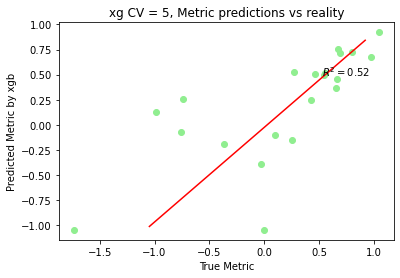

In [15]:
y = data.Metric
train_predict_xgb(y, X2)

In [16]:
#============================================================================================================
def train_predict_rf(y, var_df, category):
    target = y
    #target = norm['total compensation']
    X = var_df
    #splitting into train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, 
                                                    random_state=17)


    #xclass = xgb.XGBRegressor(booster = 'dart')
    rf2 = RandomForestRegressor()

    parameters = {
        #'learning_rate': [.01, .02, .03, .04, .05], # np.arange(.01, 1, .01), #LOOK AT INCREASING STEP SIZES
        'min_samples_split': [2,4,6,8],
        'max_depth': [25, 30, 35, 37, 40, 45, 50], #np.arange(1, 100, 1), #
        #'min_child_samples': [1, 3, 5], #np.arange(1, 15, 2), #,
        'min_samples_leaf': [1, 2, 3],
        #'subsample': np.arange(.3, .7, .1),
        #'colsample_bytree': np.arange(.1, 1, .1),
        'n_estimators' :[700, 800, 900, 1000, 1100, 1200], #np.arange(100, 1200, 100), #
        #'objective': ['reg:squarederror'],  
        }
 
    #gs = RandomizedSearchCV(xclass, parameters, cv = 5
    #gs.fit(X_train, y_train)
    
    gs2 = RandomizedSearchCV(rf2, parameters, cv = 5)
    gs2.fit(X_train, y_train)
    
    #adjusting back from the log that we took 
    rf_pred2 = gs2.predict(X_test)

    mae_rf = mean_absolute_error(rf_pred2, y_test)
    print("mean_absolute_error")
    print(mae_rf)    
    print(" ")
    print("root_mean_squarered_error")
    mse_rf = (mean_squared_error(rf_pred2, y_test))**(1/2)
    print(mse_rf)

    plt.scatter(x = rf_pred2, y = y_test, color = "blue")
    plt.title("Random Forest CV = 5")
    plt.xlabel('True Metric')
    plt.ylabel("Predicted Metric")
    trendline(rf_pred2, y_test)
    plt.show()
    
    print(gs2.error_score) 
    
    y = np.sort(gs2.best_estimator_.feature_importances_)[::-1]
    x = X.columns[np.argsort(gs2.best_estimator_.feature_importances_)[::-1]]
    plt.barh(x[:10],y[:10])
    plt.tight_layout()
    plt.xlabel('Feature importance on testing')
    plt.ylabel('Feature name')
    plt.title('Feature importances in Prediction of Metric for ' + str(category)+' data set')
    plt.show() 
    #print(gs2)
    #from sklearn import tree
    #tree.plot_tree(gs2.best_estimator_.estimators_[0], max_depth=3,)
    
    return gs2, mse_rf, mae_rf

mean_absolute_error
0.2877319909767155
 
root_mean_squarered_error
0.39650677821061997


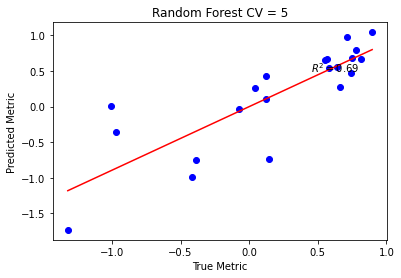

nan


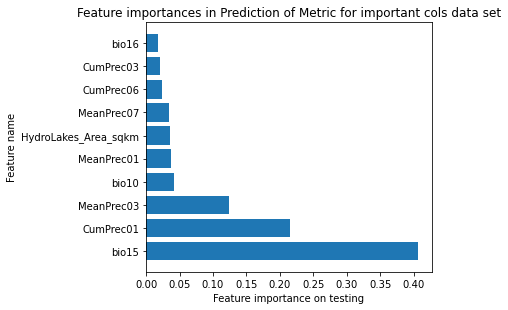

In [17]:
rf, mse_rf, mae_rf = train_predict_rf(y, X2, "important cols")

gonna run this on the whole data set, see what happens, i know its not worlds best idea for a random forest, because I have only 4 more observations than columns, so I understand that this won't be great cuz the  noise,  but just curious 

mean_absolute_error
0.3363155012648777
 
root_mean_squarered_error
0.4319510653721912


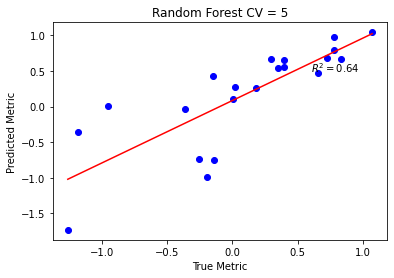

nan


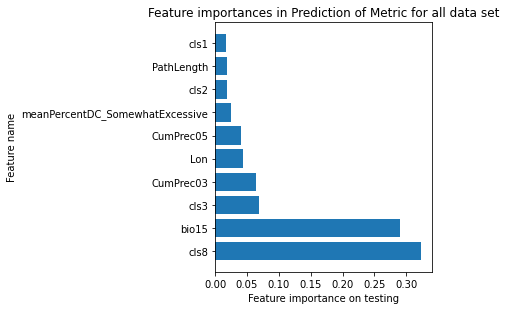

(RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                    param_distributions={'max_depth': [25, 30, 35, 37, 40, 45,
                                                       50],
                                         'min_samples_leaf': [1, 2, 3],
                                         'min_samples_split': [2, 4, 6, 8],
                                         'n_estimators': [700, 800, 900, 1000,
                                                          1100, 1200]}),
 0.4319510653721912,
 0.3363155012648777)

In [19]:
train_predict_rf(y, data[all_cols.cols.tolist()], "all")


Still not that great, I did get a slightly different feature set when we did the random forest on the columns pulled from the lasso regression of all data sets, but roughtly about the same RMSE and MAE. the data I've used and the methodologies have done an ok job at predicting, but it isn't great... I am going to try some PCA to see if that does any better, so we'll see what happens 

In [22]:
X2.shape

(102, 15)

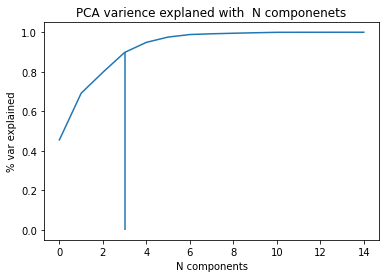

In [23]:
pca = PCA(n_components=15)

X2_pca = pca.fit_transform(X2)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[3],x=3)
plt.title("PCA varience explaned with  N componenets")
plt.ylabel("% var explained")
plt.xlabel("N components")
plt.show()

Ok so again we are getting most of the imformation through 3 principal components, so we will see how to use this in prediction 

In [24]:
pca = PCA(n_components=3)
X2_pca = pca.fit_transform(X2)
print(X2_pca.shape)
rf = RandomForestRegressor()
parameters = {
        'min_samples_split': [2,4,6,8],
        'max_depth': [25, 30, 35, 37, 40, 45, 50], 
        'min_samples_leaf': [1, 2, 3],
        'n_estimators' :[700, 800, 900, 1000, 1100, 1200],
        }
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X2_pca, y)
gs2 = RandomizedSearchCV(rf, parameters, cv = 5)

gs2.fit(X_train_pca, y_train_pca)
gs2.predict(X_test_pca)
mse_rf = (mean_squared_error(gs2.predict(X_test_pca), y_test_pca))**(1/2)
print(mse_rf)

(102, 3)
0.519037148956165


Ok so this wasn't a great approach either.. The PCA approach actually has a higher root mean squared error than 

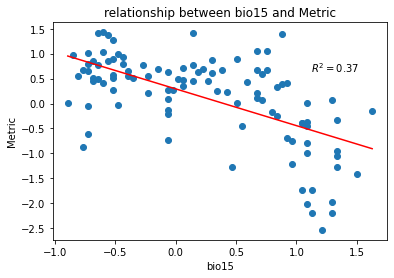

In [25]:
plt.scatter(x = data.bio15, y = data.Metric)
trendline(data.bio15, data.Metric)
plt.title("relationship between bio15 and Metric")
plt.xlabel("bio15")
plt.ylabel("Metric")
plt.show()

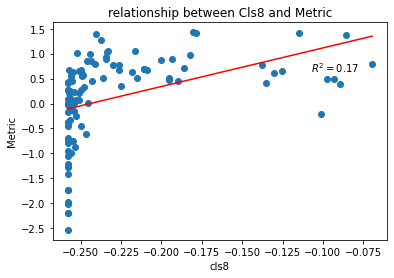

In [26]:
plt.scatter(x = data.cls8, y = data.Metric)
trendline(data.cls8, data.Metric)
plt.title("relationship between Cls8 and Metric")
plt.xlabel("cls8")
plt.ylabel("Metric")
plt.show()

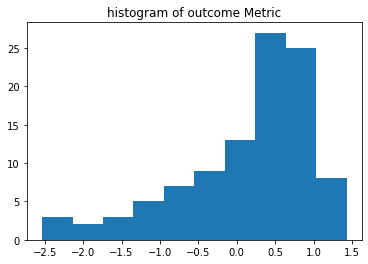

In [27]:
plt.hist(data.Metric)
plt.title("histogram of outcome Metric")
plt.show()

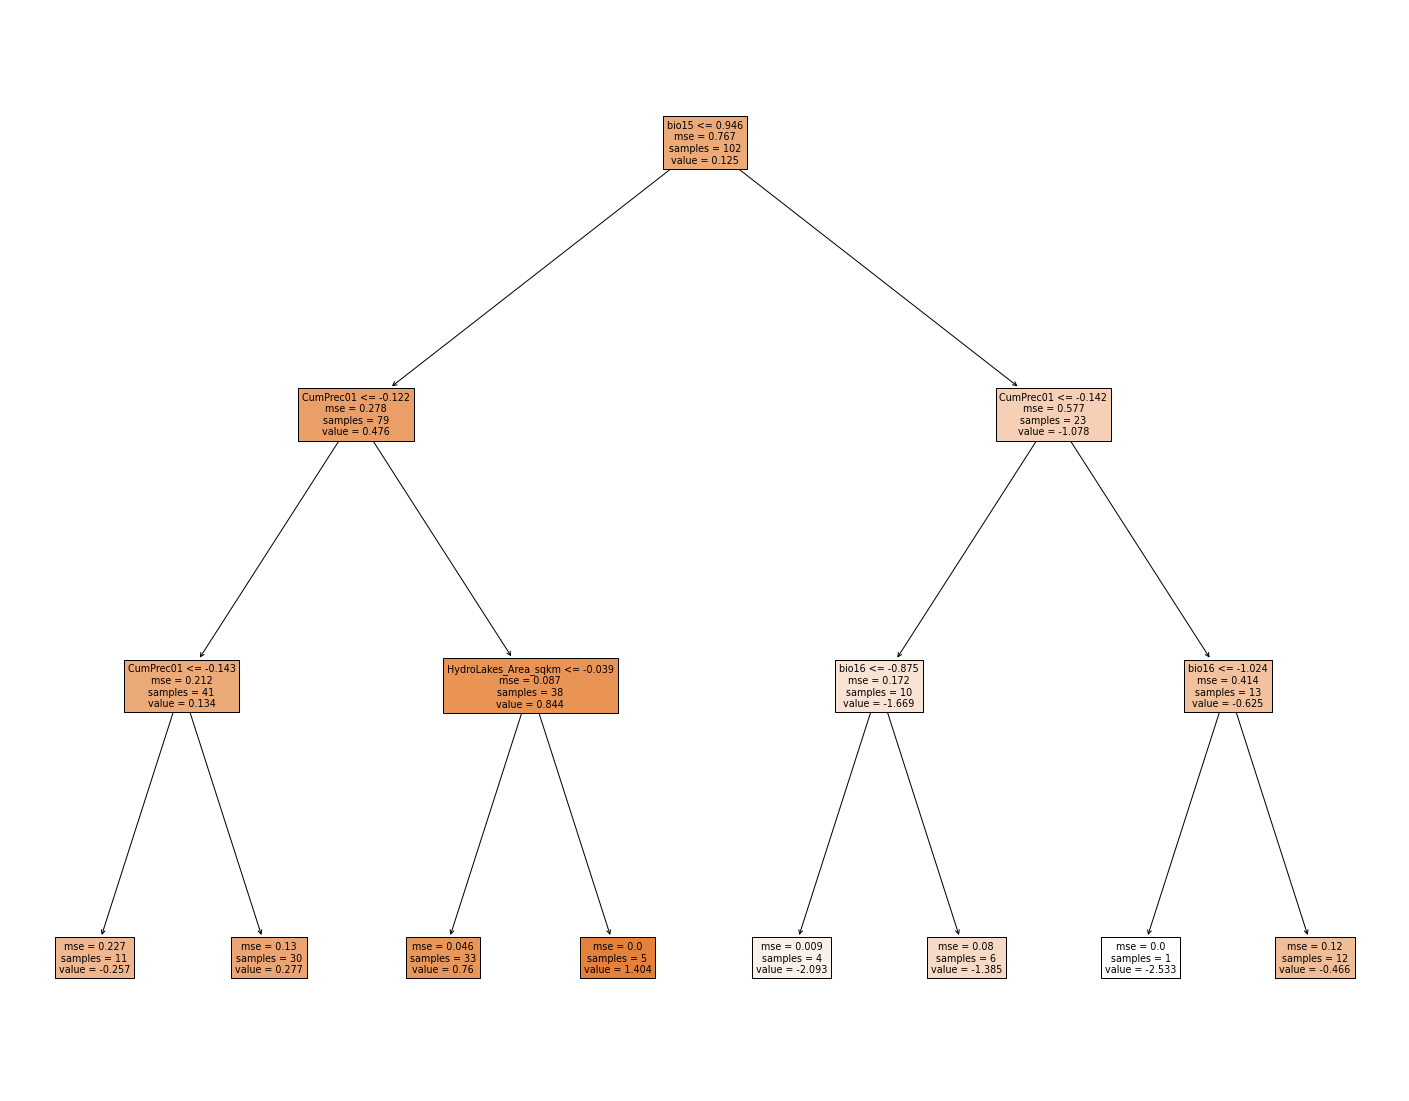

In [29]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
# Fit the regressor, set max_depth = 3
regr = DecisionTreeRegressor(max_depth=3, random_state=1234)
model = regr.fit(X2, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, feature_names=X2.columns, filled=True)

mean_absolute_error
0.3038855488865277
 
root_mean_squarered_error
0.4158519035312354


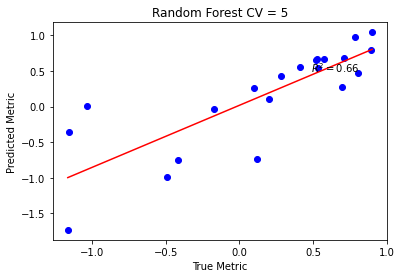

nan


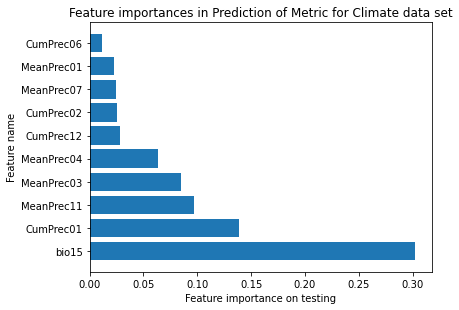

(RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                    param_distributions={'max_depth': [25, 30, 35, 37, 40, 45,
                                                       50],
                                         'min_samples_leaf': [1, 2, 3],
                                         'min_samples_split': [2, 4, 6, 8],
                                         'n_estimators': [700, 800, 900, 1000,
                                                          1100, 1200]}),
 0.4158519035312354,
 0.3038855488865277)

In [30]:
train_predict_rf(y, c, 'Climate')

In [31]:
important_features = data[['HydroLakes_Area_sqkm', 'MeanHumanFootprint', 'Dam_SurfaceArea', 
                          'MeanPopden_2000', "MeanPopden_2015", "MeanPopden_2005", "MeanPopden_2010",
                          'Dam_Count',
                          'PathLength', "TotalLength", "drain_den", 'gelev_m', 'Magnitude', 
                          'strmDrop', 'length_km', 'area_sqkm', 'garea_sqkm', 'gord',
                          'bio15', 'CumPrec01', 'MeanPrec11', 'MeanPrec04', 'MeanPrec03', 
                          'CumPrec12', 'CumPrec02', 'MeanPrec01', 'MeanPrec07', 'CumPrec11']]

mean_absolute_error
0.29958152646350805
 
root_mean_squarered_error
0.42095037262216206


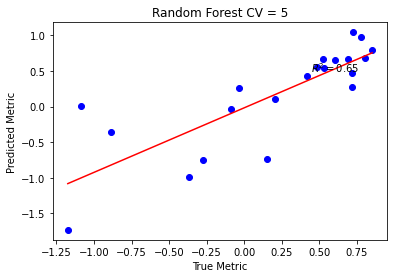

nan


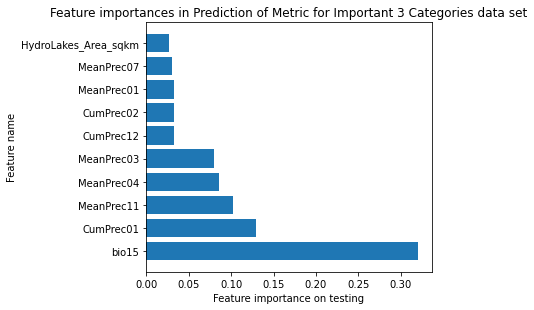

(RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                    param_distributions={'max_depth': [25, 30, 35, 37, 40, 45,
                                                       50],
                                         'min_samples_leaf': [1, 2, 3],
                                         'min_samples_split': [2, 4, 6, 8],
                                         'n_estimators': [700, 800, 900, 1000,
                                                          1100, 1200]}),
 0.42095037262216206,
 0.29958152646350805)

In [32]:
train_predict_rf(y, important_features, 'Important 3 Categories')

mean_absolute_error
0.30009968783838703
 
root_mean_squarered_error
0.4042425505035258


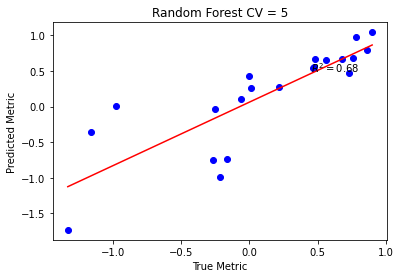

nan


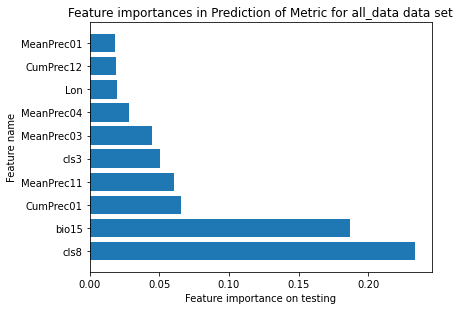

(RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                    param_distributions={'max_depth': [25, 30, 35, 37, 40, 45,
                                                       50],
                                         'min_samples_leaf': [1, 2, 3],
                                         'min_samples_split': [2, 4, 6, 8],
                                         'n_estimators': [700, 800, 900, 1000,
                                                          1100, 1200]}),
 0.4042425505035258,
 0.30009968783838703)

In [33]:
train_predict_rf(y, cols, 'all_data')

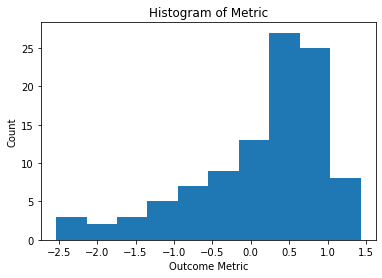

In [34]:
plt.hist(data.Metric)
plt.title("Histogram of Metric")
plt.xlabel("Outcome Metric")
plt.ylabel("Count")
plt.show()

len of training
81
len of testing
21
mean_absolute_error
0.26668522146241014
 
root_mean_squarered_error
0.3883821325108889
nan


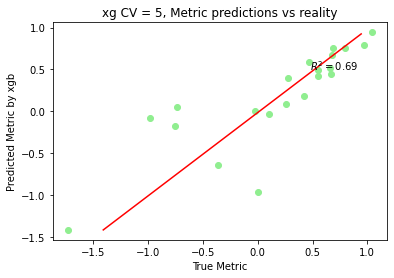

In [35]:
train_predict_xgb(data.Metric, cols)